# Trabajo Práctico 2: Análisis con Redes Neuronales - Organización de Datos

**Alumnos y Padrón**  
* Grassano, Bruno - 103855  
* Romero, Adrián   - 103371

https://github.com/brunograssano/TP-Organizacion-de-datos

## Configuraciones Iniciales

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from numpy.random import seed
seed(42)

In [2]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
from sklearn.model_selection import GridSearchCV

In [3]:
import tensorflow as tf
tf.random.set_seed(42)

from keras.callbacks import EarlyStopping
from tensorflow.keras import regularizers
physical_devices = tf.config.list_physical_devices('GPU')

try:
    tf.config.experimental.set_memory_growth(physical_devices[0], True)
except:
    pass

import keras
from keras.wrappers.scikit_learn import KerasClassifier
from keras.models import Sequential
from keras.layers import Dense, Dropout

Using TensorFlow backend.


In [4]:
from preprocessing import prepararSetDeDatos
from preprocessing import prepararSetDeHoldout
from preprocessing import prepararSetDeValidacion
from preprocessing import conversionAVariablesNormalizadas

In [5]:
from funcionesAuxiliares import escribirPrediccionesAArchivo
from funcionesAuxiliares import obtenerDatasets
from funcionesAuxiliares import obtenerHoldout

## Carga y preparación del set de datos

Cargamos los sets de datos que se usarán para el entrenamiento y validación.

In [6]:
X, y = obtenerDatasets() 

X = prepararSetDeDatos(X)
y = prepararSetDeValidacion(y)

## Funciones Auxiliares


In [7]:
def graficarPerdidaDelModelo(historia_modelo):
    plt.figure(dpi=125, figsize=(10, 3))
    plt.plot(historia_modelo.history['loss'], label="Training loss")
    plt.plot(historia_modelo.history['val_loss'], label="Validation loss")
    plt.title('Loss del modelo')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend()
    plt.show()

In [8]:
def entrenarModelo(modelo, epocas, tamanio_entrenamiento):
    historia = modelo.fit(X_train, y_train, epochs=epocas, batch_size=tamanio_entrenamiento, verbose=0, validation_split=0.25)
    return historia, modelo

In [9]:
# No se utiliza la de funcionesAuxiliares debido a que en este caso se tiene otro array. (en predict_proba [:,1]) (idem en mostrar el AUCScore)
def graficarROCCurve(modelo,nombreModelo,X_test, X_train, y_test, y_train):
    fpr_test, tpr_test, thresholds_test = roc_curve(y_test, modelo.predict_proba(X_test))
    fpr_train, tpr_train, thresholds_train = roc_curve(y_train, modelo.predict_proba(X_train))

    zero_test = np.argmin(np.abs(thresholds_test))
    zero_train = np.argmin(np.abs(thresholds_train))

    plt.plot(fpr_test, tpr_test, label="ROC Curve "+nombreModelo+" Test")
    plt.plot(fpr_train, tpr_train, label="ROC Curve  " + nombreModelo + " Train")
    plt.xlabel("FPR")
    plt.ylabel("TPR")
    plt.plot(fpr_test[zero_test], tpr_test[zero_test], 'o', markersize=10, label="threshold zero test",
             fillstyle="none", c="k", mew=2)
    plt.plot(fpr_train[zero_train], tpr_train[zero_train], 'x', markersize=10, label="threshold zero train",
             fillstyle="none", c="k", mew=2)
    plt.legend(loc=4)
    plt.show()

## Redes Neuronales

Las redes neuronales están dentro de lo que se considera modelos más complejos. Este tipo de modelo dispone de una amplia cantdidad de parámetros que se pueden ir modificando hasta obtener los mejores resultados.

Para el preprocesamiento decidimos utilizar el mismo tipo de función que en otros modelos. Este preprocesamiento encodea las variables categóricas mediante OneHotEncoding y normaliza las variables numéricas.

In [10]:
X_redes_neuronales = conversionAVariablesNormalizadas(X)

In [11]:
X_train, X_test, y_train, y_test = train_test_split(X_redes_neuronales, y, test_size=0.25, random_state=0)

Los **parámetros** que tendremos en cuenta al entrenar las redes neuronales seran:

* **Función de pérdida a optimizar:** Es la función que se busca minimizar. En nuestro caso como deseamos hacer una clasificación binaria, es decir, entre dos clases, utilizaremos siempre la función: binary cross entropy

* **Optimizador:** Es el algoritmo mediante el cual se optimiza el función de perdida anterior. Utilizaremos Stochastic Gradient Descent (SGD) y Adam. La diferencia principal radica en que Adam es un optimizador que considera a la derivada segunda para realizar la optimización mientras que SGD solo la derivada primera. Esto puede llegar a suavizar la pérdida al entrenar la red a lo largo de las épocas. 

* **Tasa de aprendizaje:** Es un parámetro que indica la velocidad con la cual el optimizador intenta acercarse el mínimo de la función de pérdida. Una tasa pequeña, requerirá más iteraciones para alcanzar el mínimo y una muy grande podría nunca encontrarlo, por ejemplo ya que se lo saltea constantemente.

* **Funcion de activacion de las neuronas:** Es la función que se aplica sobre el input de cada neurona, antes de multiplicarla por el peso correspondiente. Hemos probado las siguientes: ReLu, sigmoidea y tanh

* **Cantidad de capas:** Es la cantidad de capas de la red. Consideramos que teniendo una capa de input, una oculta y una de output era suficiente. Esto es porque agregando capas el tiempo de entrenamiento se volvía poco razonable y posiblemente más complicado de lo necesario.

* **Cantidad de neuronas de cada capa:** Hemos entrenado con la siguiente configuración de la red: La primera capa tiene 14 neuronas pues tenemos 14 features. La última capa tiene 1, lo cual nos servirá para realizar la clasificación en los 2. 

Además, en algunas redes, utilizamos **dropout:** durante el entrenamiento, algunas de las neuronas no se tienen en cuenta. Esto puede volver más robusto al modelo, al hacer que la salida del mismo no depende únicamente de un camino.

# Ver si usamos regularizacion l1 o l2!!!!!!!!!!!

Empezamos ahora armando una red neuronal sencilla para ver cómo es su desempeño.

In [12]:
red_neuronal1 = Sequential()
red_neuronal1.add(Dense(14, input_dim=14, activation='relu'))
red_neuronal1.add(Dense(6, activation='tanh'))
red_neuronal1.add(Dense(1, activation='sigmoid'))
red_neuronal1.compile(loss='binary_crossentropy', optimizer="SGD", metrics=[tf.keras.metrics.AUC()])

Mostramos el resumen de como queda armada.

In [13]:
red_neuronal1.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 14)                210       
_________________________________________________________________
dense_2 (Dense)              (None, 6)                 90        
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 7         
Total params: 307
Trainable params: 307
Non-trainable params: 0
_________________________________________________________________


Ahora finalmente entrenamos con el set de entrenamiento.

In [14]:
h, red_neuronal1 = entrenarModelo(red_neuronal1, 500, 50)

Observamos cómo se fue desarrollando la funcion de pérdida para el entrenamiento y la validación de la red.

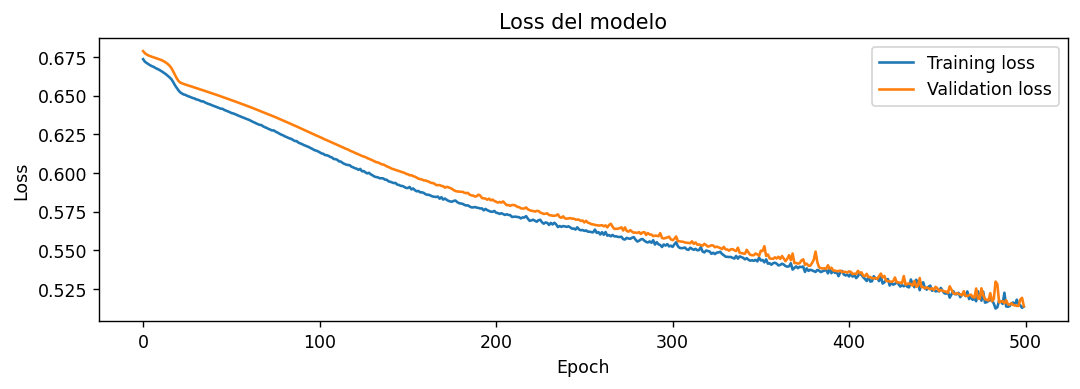

In [15]:
graficarPerdidaDelModelo(h)

Ahora buscamos las métricas que nos interesan sobre el set de evaluación guardado anteriormente.

In [16]:
y_pred = red_neuronal1.predict(X_test)

In [17]:
print(classification_report(y_test, y_pred.round(), target_names=['No vuelve','Vuelve'])) ### REVISAR, SE ESTA REDONDEANDO PARA QUE PUEDA USARSE LA FUNCION

              precision    recall  f1-score   support

   No vuelve       0.72      0.85      0.78       121
      Vuelve       0.68      0.49      0.57        80

    accuracy                           0.71       201
   macro avg       0.70      0.67      0.67       201
weighted avg       0.70      0.71      0.69       201



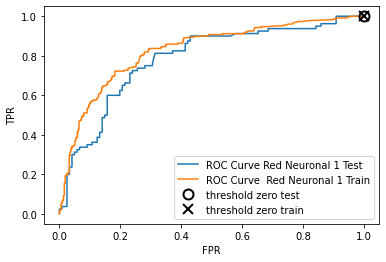

In [18]:
graficarROCCurve(red_neuronal1,"Red Neuronal 1",X_test, X_train, y_test, y_train)

In [19]:
auc_red = roc_auc_score(y_test,red_neuronal1.predict_proba(X_test))
print("AUC para redes neuronales 1: {:.3f}".format(auc_red))

AUC para redes neuronales 1: 0.784


Vemos que se obtuvieron resultados que estan bien, pero que pueden mejorarse. Una cosa que se destaca es que en el gráfico del entrenamiento aparece como que todavía puede seguir aprendiendo. Probamos aumentando la cantidad de épocas.

In [20]:
red_neuronal2 = Sequential()
red_neuronal2.add(Dense(14, input_dim=14, activation='relu'))
red_neuronal2.add(Dense(6, activation='tanh'))
red_neuronal2.add(Dense(1, activation='sigmoid'))
red_neuronal2.compile(loss='binary_crossentropy', optimizer="SGD", metrics=[tf.keras.metrics.AUC()])

In [21]:
h, red_neuronal2 = entrenarModelo(red_neuronal2, 800, 50)

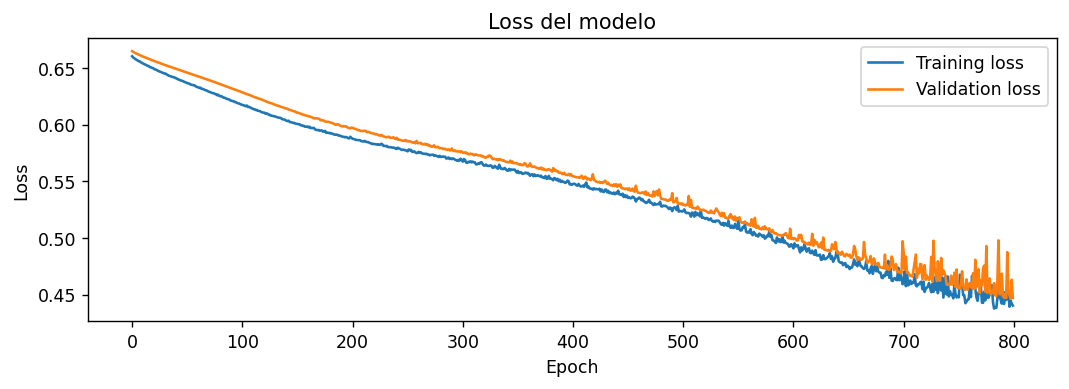

In [22]:
graficarPerdidaDelModelo(h)

In [23]:
y_pred = red_neuronal2.predict(X_test)

In [24]:
print(classification_report(y_test, y_pred.round(), target_names=['No vuelve','Vuelve'])) ### REVISAR, SE ESTA REDONDEANDO PARA QUE PUEDA USARSE LA FUNCION

              precision    recall  f1-score   support

   No vuelve       0.79      0.80      0.80       121
      Vuelve       0.69      0.68      0.68        80

    accuracy                           0.75       201
   macro avg       0.74      0.74      0.74       201
weighted avg       0.75      0.75      0.75       201



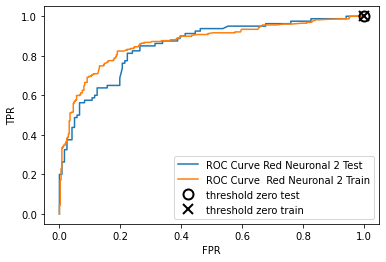

In [25]:
graficarROCCurve(red_neuronal2,"Red Neuronal 2",X_test, X_train, y_test, y_train)

In [26]:
auc_red = roc_auc_score(y_test,red_neuronal2.predict_proba(X_test))
print("AUC para redes neuronales: {:.3f}".format(auc_red))

AUC para redes neuronales: 0.852


Vemos que aprendió bastante más y mejoró la métrica, pero que ya en el entrenamiento se empiezan a ver picos hacia el final. Probamos mejorarlo cambiando el optimizador a 'Adam'.

In [27]:
red_neuronal3 = Sequential()
red_neuronal3.add(Dense(14, input_dim=14, activation='relu'))
red_neuronal3.add(Dense(6, activation='tanh'))
red_neuronal3.add(Dense(1, activation='sigmoid'))
optimizador = keras.optimizers.Adam()
red_neuronal3.compile(loss='binary_crossentropy', optimizer=optimizador, metrics=[tf.keras.metrics.AUC()])

In [28]:
h, red_neuronal3 = entrenarModelo(red_neuronal3, 800, 50)

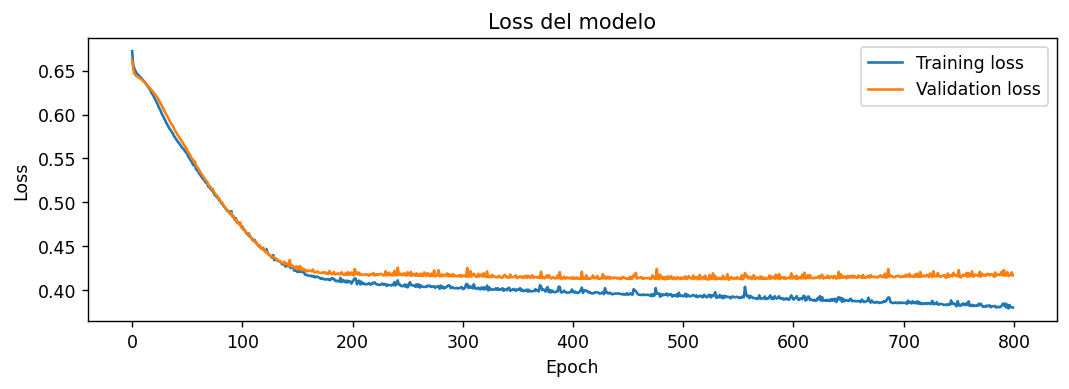

In [29]:
graficarPerdidaDelModelo(h)

In [30]:
y_pred = red_neuronal3.predict(X_test)

In [31]:
print(classification_report(y_test, y_pred.round(), target_names=['No vuelve','Vuelve'])) ### REVISAR, SE ESTA REDONDEANDO PARA QUE PUEDA USARSE LA FUNCION

              precision    recall  f1-score   support

   No vuelve       0.84      0.88      0.86       121
      Vuelve       0.80      0.75      0.77        80

    accuracy                           0.83       201
   macro avg       0.82      0.81      0.82       201
weighted avg       0.82      0.83      0.82       201



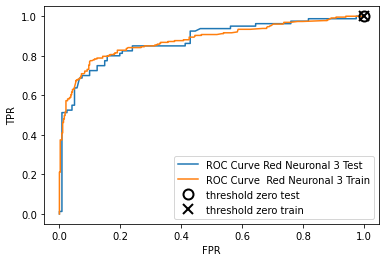

In [32]:
graficarROCCurve(red_neuronal3,"Red Neuronal 3",X_test, X_train, y_test, y_train)

In [33]:
auc_red = roc_auc_score(y_test,red_neuronal3.predict_proba(X_test))
print("AUC para redes neuronales: {:.3f}".format(auc_red))

AUC para redes neuronales: 0.877


Vemos que volvió a mejorar. Probamos agregando algunas capas de 'Dropout' y bajamos las epocas a 350, así no empieza a separarse hacia el final la función de pérdida. 

In [34]:
red_neuronal4 = Sequential()
red_neuronal4.add(Dense(14, input_dim=14, activation='relu'))
red_neuronal4.add(Dropout(0.1))
red_neuronal4.add(Dense(6, activation='tanh'))
red_neuronal4.add(Dense(1, activation='sigmoid'))
optimizador = keras.optimizers.Adam()
red_neuronal4.compile(loss='binary_crossentropy', optimizer=optimizador, metrics=[tf.keras.metrics.AUC()])

In [35]:
h, red_neuronal4 = entrenarModelo(red_neuronal4, 350, 50)

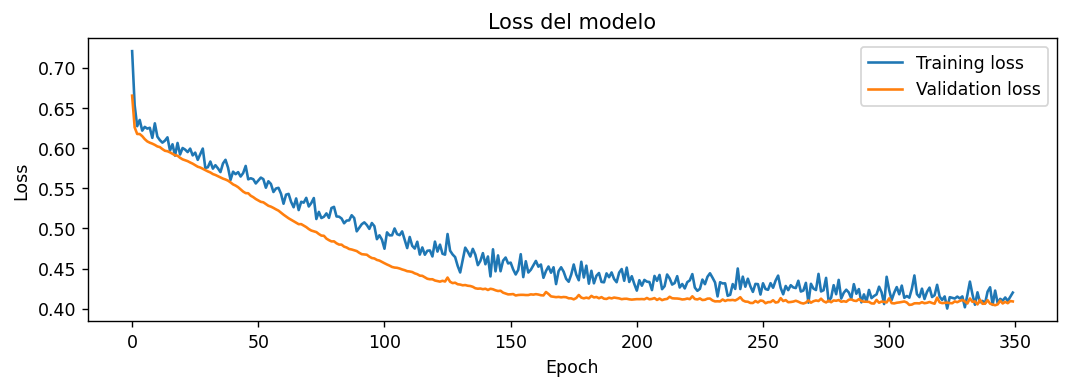

In [36]:
graficarPerdidaDelModelo(h)

In [37]:
y_pred = red_neuronal4.predict(X_test)

In [38]:
print(classification_report(y_test, y_pred.round(), target_names=['No vuelve','Vuelve'])) ### REVISAR, SE ESTA REDONDEANDO PARA QUE PUEDA USARSE LA FUNCION

              precision    recall  f1-score   support

   No vuelve       0.80      0.90      0.85       121
      Vuelve       0.82      0.66      0.73        80

    accuracy                           0.81       201
   macro avg       0.81      0.78      0.79       201
weighted avg       0.81      0.81      0.80       201



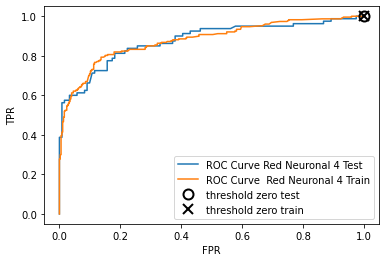

In [39]:
graficarROCCurve(red_neuronal4,"Red Neuronal 4",X_test, X_train, y_test, y_train)

In [40]:
auc_red = roc_auc_score(y_test,red_neuronal4.predict_proba(X_test))
print("AUC para redes neuronales: {:.3f}".format(auc_red))

AUC para redes neuronales: 0.877


Vemos que el resultado es el mismo que para el caso anterior, a pesar de que usamos dropout y disminuimmos las epocas. Buscamos probar ahora agregando una capa más junto a un dropout.

In [41]:
red_neuronal5 = Sequential()
red_neuronal5.add(Dense(14, input_dim=14, activation='relu'))
red_neuronal5.add(Dropout(0.1))
red_neuronal5.add(Dense(14, activation='relu'))
red_neuronal5.add(Dropout(0.1))
red_neuronal5.add(Dense(6, activation='tanh'))
red_neuronal5.add(Dense(1, activation='sigmoid'))
optimizador = keras.optimizers.Adam()
red_neuronal5.compile(loss='binary_crossentropy', optimizer=optimizador, metrics=[tf.keras.metrics.AUC()])

In [42]:
h, red_neuronal5 = entrenarModelo(red_neuronal5, 350, 50)

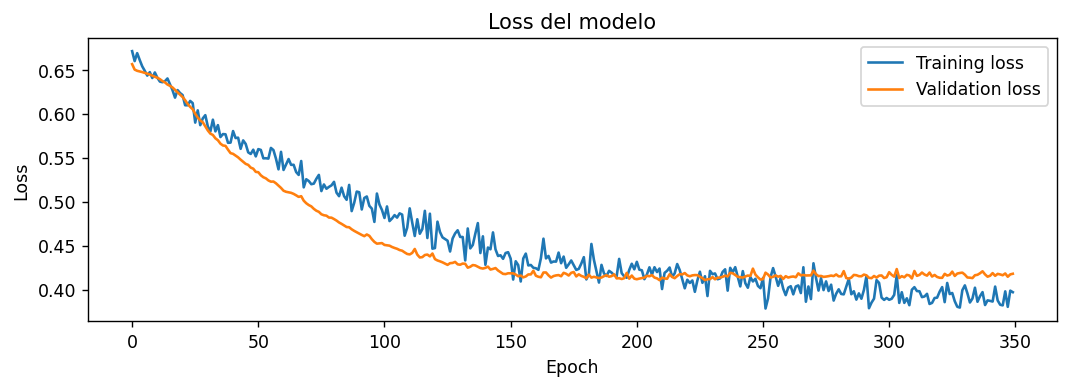

In [43]:
graficarPerdidaDelModelo(h)

In [44]:
y_pred = red_neuronal5.predict(X_test)

In [45]:
print(classification_report(y_test, y_pred.round(), target_names=['No vuelve','Vuelve'])) ### REVISAR, SE ESTA REDONDEANDO PARA QUE PUEDA USARSE LA FUNCION

              precision    recall  f1-score   support

   No vuelve       0.83      0.87      0.85       121
      Vuelve       0.78      0.72      0.75        80

    accuracy                           0.81       201
   macro avg       0.81      0.80      0.80       201
weighted avg       0.81      0.81      0.81       201



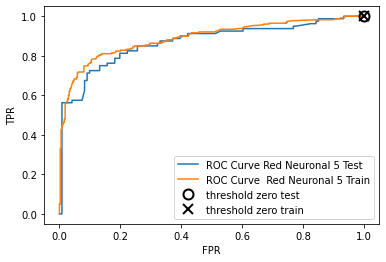

In [46]:
graficarROCCurve(red_neuronal5,"Red Neuronal 5",X_test, X_train, y_test, y_train)

In [47]:
auc_red = roc_auc_score(y_test,red_neuronal5.predict_proba(X_test))
print("AUC para redes neuronales: {:.3f}".format(auc_red))

AUC para redes neuronales: 0.869


Habiendo hecho esto, el valor de la métrica AUC se vio reducido.

## Predicciones sobre el nuevo archivo

Obtenemos y preparamos el nuevo archivo realizando el mismo preprocesamiento realizado anteriormente.

In [48]:
holdout = obtenerHoldout()

holdout = prepararSetDeHoldout(holdout)
holdout_redes = conversionAVariablesNormalizadas(holdout)

Realizamos las predicciones y escribimos al archivo CSV. Para realizar las predicciones, utilizamos el modelo que mejor resultado dio.

In [51]:
predicciones_holdout = red_neuronal4.predict(holdout_redes) 

In [50]:
escribirPrediccionesAArchivo(predicciones_holdout.round().astype(int).ravel(),"RedesNeuronales")